Load packages and data. As with R, we remove hole area raw and then remove NaN rows.

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/Users/Deathvoodoo/Documents/semb_int/TableTilLars.csv').drop('hole_area_raw', axis=1).dropna()
#data = pd.read_csv('/Users/Deathvoodoo/Documents/semb_int/table_2_full.csv').drop('hole_area_raw', axis=1).dropna()

In [3]:
data.head()

,data_set_name,hole_num_inmovie,hole_num_rep,tissue_type,numCon,numEnds,period,hole_area_smooth,dAdt,dEdt,eccentricity,solidity,numEnds_over_numCon
0,pos1,1,1,Periphery,5,3,12.666667,704.956059,-23.100122,-0.004848,0.862981,0.936042,0.6
1,pos1,1,1,Periphery,5,3,12.666667,681.855937,-23.829050,-0.004710,0.858133,0.937286,0.6
2,pos1,1,1,Periphery,5,3,12.666667,658.026886,-24.416207,-0.004525,0.853423,0.938449,0.6
3,pos1,1,1,Periphery,5,3,12.666667,633.610679,-24.767005,-0.004324,0.848898,0.939512,0.6
4,pos1,1,1,Periphery,5,3,12.666667,608.843674,-24.914124,-0.004142,0.844574,0.940474,0.6


In [4]:
data.shape

(3070, 13)

In [5]:
data.keys()

Index(['data_set_name', 'hole_num_inmovie', 'hole_num_rep', 'tissue_type',
       'numCon', 'numEnds', 'period', 'hole_area_smooth', 'dAdt', 'dEdt',
       'eccentricity', 'solidity', 'numEnds_over_numCon'],
      dtype='object')

We'll use the same parameters as in the linear models, i.e. dropping dEdt and numEnds_over_numCon

In [6]:
predictors = ['numCon', 'numEnds', 'period', 'hole_area_smooth', 'eccentricity', 'solidity']

We first shuffle the data and split it into a train and a test set. It is often common to split randomly, but given that our data is actually a time-series, that means that some samples will be highly correlated between training and test set, i.e. we can also split justt by the holes themselves into an approximately 0.8/0.2 split

In [7]:
# check hole series sizes
hole_ids = np.unique(data['hole_num_rep'])
hole_sizes = {}
for hole in hole_ids:
    hole_sizes[hole] = data.loc[data['hole_num_rep']==hole].shape[0]
print(hole_sizes)

{1: 20, 2: 19, 3: 54, 4: 12, 5: 159, 6: 55, 7: 66, 8: 177, 9: 73, 10: 33, 11: 40, 12: 57, 13: 225, 14: 225, 15: 223, 16: 202, 17: 45, 18: 24, 19: 225, 20: 44, 22: 170, 24: 120, 25: 160, 26: 155, 27: 130, 28: 59, 29: 18, 30: 89, 31: 120, 32: 71}


In [8]:
# let's sample some holes to make a training set and a test set
def sample_metapoints(dataset, train_fraction, metapoint_id):
    metapoint_ids = np.unique(dataset[metapoint_id])
    metapoint_sizes = {}
    for mp in metapoint_ids:
        metapoint_sizes[mp] = dataset.loc[dataset[metapoint_id]==mp].shape[0]
    metapoints = list(np.random.permutation(metapoint_ids))
    sum_frames = 0
    train_metapoints = []
    test_metapoints = []
    while sum_frames <= dataset.shape[0]*train_fraction:
        metapoint_i = metapoints.pop()
        if (sum_frames + metapoint_sizes[metapoint_i]) > dataset.shape[0]*train_fraction:
            test_metapoints.append(metapoint_i)
            break
        else:
            sum_frames += metapoint_sizes[metapoint_i]
        train_metapoints.append(metapoint_i)
    test_metapoints += metapoints
    return([train_metapoints, test_metapoints])
    

In [9]:
holes_train, holes_test = sample_metapoints(data, 0.8, 'hole_num_rep')
pancrea_train = data.loc[np.isin(data['hole_num_rep'], holes_train)]
pancrea_test = data.loc[np.isin(data['hole_num_rep'], holes_test)]
pancrea_trainx = pancrea_train[predictors].to_numpy()
pancrea_trainy = pancrea_train['dAdt'].to_numpy()
pancrea_testx = pancrea_test[predictors].to_numpy()
pancrea_testy = pancrea_test['dAdt'].to_numpy()

In [10]:
# check what holes is in what split
print(np.unique(pancrea_train['hole_num_rep']), pancrea_train.shape)
print(np.unique(pancrea_test['hole_num_rep']), pancrea_test.shape)

[ 1  2  4  5  7  8  9 10 12 13 14 16 17 18 19 22 24 25 26 27 28 30] (2445, 13)
[ 3  6 11 15 20 29 31 32] (625, 13)


In [11]:
# this function is for randomly splitting the data frame
def split_data(pd_df, feature_names, y_names, train_fraction):
    inds_shuffled = np.random.permutation(np.arange(0, pd_df.shape[0]))
    train_to = int(np.round(inds_shuffled.shape[0] * train_fraction))
    train_inds = inds_shuffled[0:train_to]
    test_inds = inds_shuffled[train_to:]
    train_set = pd_df.iloc[train_inds]
    test_set = pd_df.iloc[test_inds]
    trainX = train_set[feature_names].to_numpy()
    trainY = train_set[y_names].to_numpy()
    testX = test_set[feature_names].to_numpy()
    testY = test_set[y_names].to_numpy()
    return [trainX, trainY, testX, testY]
#pancrea_trainx, pancrea_trainy, pancrea_testx, pancrea_testy = split_data(data, predictors, 
                                                                          #'dAdt', train_fraction = 0.8)


Now we can fit the model. We use SKLearn's random forest regressor implementation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [12]:
pancreas_rf_regressor = RandomForestRegressor(n_estimators=100, max_features=len(predictors))
pancreas_rf_regressor.fit(pancrea_trainx, pancrea_trainy)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [13]:
# we can check what parameters are default
pancreas_rf_regressor.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 6,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Before we try to optimize things with hyperparameter selection etc.let's just see how this default model with 100 trees does on the training data and test data. We define some functions to evaluate the loss.

In [14]:
predicted_train = pancreas_rf_regressor.predict(pancrea_trainx)

In [15]:
def squared_loss(y_true, y_pred):
    loss=np.sum((y_true - y_pred)**2)/y_true.shape[0]
    return(loss)
def r_squared(y_true, y_pred):
    true_mean = np.mean(y_true)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - true_mean)**2)
    rsq = 1 - ss_res/ss_tot
    return(rsq)
def correlation_(y_1, y_2):
    y1 = np.copy(y_1) - np.mean(y_1)
    y2 = np.copy(y_2) - np.mean(y_2)
    covar = np.dot(y1, y2)
    sd1 = np.sqrt(np.dot(y1, y1))
    sd2 = np.sqrt(np.dot(y2, y2))
    correlation = covar/(sd1*sd2)
    return(correlation)

In [16]:
# quickly evaluate the performance on the training set
print(squared_loss(pancrea_trainy, predicted_train))
print(r_squared(pancrea_trainy, predicted_train))

13.21936150685762
0.989523646378828


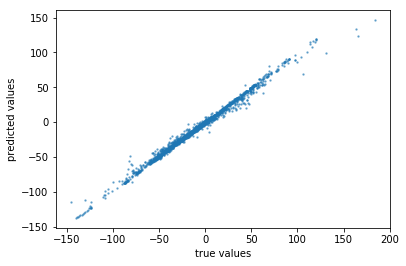

In [17]:
# plot the predicted values against the true values
plt.scatter(pancrea_trainy, predicted_train, s=2, alpha=0.5)
plt.ylabel('predicted values')
plt.xlabel('true values')
plt.show()

In [18]:
# evaluate performance on the test set
predicted_test = pancreas_rf_regressor.predict(pancrea_testx)
print('mean squared error for test set: {}'.format(squared_loss(pancrea_testy, predicted_test)))
print('correlation for training predictions and true values: {}'.format(correlation_(predicted_train, pancrea_trainy)))
print('correlation for test predictions and true values: {}'.format(correlation_(predicted_test, pancrea_testy)))

mean squared error for test set: 5835.238356073356
correlation for training predictions and true values: 0.9956962369759477
correlation for test predictions and true values: -0.11991171009701379


In [19]:
def plot_hole_results(true, predicted, hole_vector):
    fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=100)
    holes_unique = np.unique(hole_vector)
    #cmap1 = plt.cm.get_cmap('magma', len(holes_unique))
    cmap2 = plt.cm.rainbow(np.linspace(0, 1, len(holes_unique)))
    for i in range(len(holes_unique)):
        hole = holes_unique[i]
        cmap_float = i/len(holes_unique)
        nrows_i = np.sum(hole_vector==hole)
        #color_matrix = np.repeat(np.atleast_2d(cmap(cmap_float)), nrows_i, axis=0)
        color_matrix = np.repeat(np.atleast_2d(cmap2[i]), nrows_i, axis=0)
        ax.scatter(true[hole_vector==hole, ], predicted[hole_vector==hole, ], 
                    s = 5, alpha = 1, c = color_matrix, label=hole)

    ax.set_ylabel('predicted values')
    ax.set_xlabel('true values')
    min_val = (min(min(true), min(predicted)))
    max_val = (max(max(true), max(predicted)))
    ax.plot([min_val, max_val], [min_val, max_val], c='black', )
    ax.legend(loc='lower right')
    ax.set_aspect('equal', 'box')
    #ax.set_ylim(min_val max_val)
    #ax.set_xlim(min_val, max_val)
    ax.set_xticks(ax.get_yticks())
    #plt.plot([-300,200], [-300,200], c='red')
    return(plt.show())

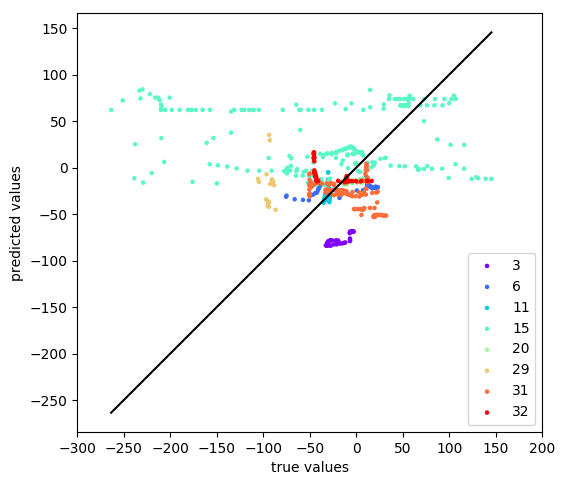

In [20]:
plot_hole_results(pancrea_testy, predicted_test, pancrea_test['hole_num_rep'].to_numpy())

In [21]:
np.unique(pancrea_test['hole_num_rep'], return_counts=True)

(array([ 3,  6, 11, 15, 20, 29, 31, 32]),
 array([ 54,  55,  40, 223,  44,  18, 120,  71]))

Let's do 5 fold cross validation and search for some hyperparameters. We can check what our initial model already does and go from there.

In [22]:
# let's try to see what kind of depths our trees are obtaining
print([estimator.tree_.max_depth for estimator in pancreas_rf_regressor.estimators_],)

[26, 25, 25, 28, 25, 27, 27, 24, 31, 29, 27, 26, 29, 34, 27, 28, 26, 25, 32, 28, 27, 27, 26, 26, 27, 26, 27, 26, 25, 25, 29, 25, 23, 25, 31, 29, 33, 23, 28, 27, 29, 28, 27, 23, 26, 24, 28, 27, 27, 29, 25, 25, 23, 23, 23, 27, 28, 30, 27, 26, 28, 26, 24, 26, 21, 28, 25, 28, 25, 24, 27, 24, 28, 24, 28, 23, 24, 23, 26, 27, 25, 32, 27, 28, 28, 31, 29, 26, 25, 31, 31, 25, 27, 28, 27, 26, 25, 29, 29, 32]


check which type of attributes the tree_ thingy has

In [23]:
print(dir(pancreas_rf_regressor.estimators_[0].tree_), )

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', 'apply', 'capacity', 'children_left', 'children_right', 'compute_feature_importances', 'compute_partial_dependence', 'decision_path', 'feature', 'impurity', 'max_depth', 'max_n_classes', 'n_classes', 'n_features', 'n_leaves', 'n_node_samples', 'n_outputs', 'node_count', 'predict', 'threshold', 'value', 'weighted_n_node_samples']


In [24]:
pancreas_rf_regressor.estimators_[0].tree_.n_node_samples # i.e. we can try to increase the minimum samples at leaves

array([1533,  891,  858, ...,    2,    1,    1])

Create some hyperparameters. We vary the number of trees, the number of features to consider at each split, the maximum depth of the individual trees and the minimum number of samples at leaves.

In [25]:
n_trees_pancrea = [10, 50, 100, 500]
max_features_pancrea = [len(predictors), int(round(len(predictors)/3))]
max_depth_pancrea = [20, None]
min_samples_leaf_pancrea = [1, 2, 5]

In [26]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

Sklearn has a function that can do the cross-validation grid search. By default this function uses R^2 as 'loss' but we set it to squared loss for consistency. 
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Note that the scoring is set to "neg_mean_squared_error" since a high score = good, whereas in our functions we are looking at the loss where high loss = bad.

In [27]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': n_trees_pancrea,
    'max_features': max_features_pancrea,
    'max_depth': max_depth_pancrea,
    'min_samples_leaf': min_samples_leaf_pancrea
}
rf_reg = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf_reg, param_grid = param_grid, 
                          cv = 5, n_jobs = 2, verbose = 1, scoring='neg_mean_squared_error')

grid_search.fit(pancrea_trainx, pancrea_trainy)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   26.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 240 out of 240 | elapsed:  2.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [28]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Let's fit a model with these hyper parameters and check the performance on the training and test set.

In [29]:
rf_sklearn = RandomForestRegressor(max_depth = grid_search.best_params_['max_depth'], 
                                        max_features = grid_search.best_params_['max_features'], 
                                        min_samples_leaf = grid_search.best_params_['min_samples_leaf'], 
                                        n_estimators = grid_search.best_params_['n_estimators'])

rf_sklearn.fit(pancrea_trainx, pancrea_trainy)

pred_sklearn_train = rf_sklearn.predict(pancrea_trainx)
pred_sklearn_test = rf_sklearn.predict(pancrea_testx)

train_loss_sklearn = squared_loss(pred_sklearn_train, pancrea_trainy)
test_loss_sklearn = squared_loss(pred_sklearn_test, pancrea_testy)

print(train_loss_sklearn, test_loss_sklearn)

33.502423913361945 4505.359148982333


In [30]:
print(correlation_(pred_sklearn_train, pancrea_trainy))
print(correlation_(pred_sklearn_test, pancrea_testy))

0.9877897604030121
-0.10869038128702269


We will just use rf_sklearn for the rest of the analysis since it has lowest cross validation error.

Now we can try to get feature importance. There's already an inbuilt method to the SKLearn class actually that works by looking at the average weighted impurity decrease for each inner node.

In [31]:
feature_importance_by_loss = rf_sklearn.feature_importances_
feat_importance_dict = dict(zip(predictors, rf_sklearn.feature_importances_))
{k: v for k, v in sorted(feat_importance_dict.items(), key=lambda item: item[1])}

{'numCon': 0.04668773575235804,
 'numEnds': 0.05250670303629289,
 'period': 0.08501436841380564,
 'solidity': 0.2269849964419926,
 'eccentricity': 0.27000321609993966,
 'hole_area_smooth': 0.3188029802556112}

We can also look at how each feature decreases the training loss when we shuffle that feature and input it to the already trained model.

In [32]:
def shuffle_feature_rf(n_shuffles, feature_index, X, Y, model,
                       imp_score_type = 'difference', loss_type = 'squared_loss'):
    avg_loss = 0
    for n in range(n_shuffles):
        shuffled_inds = np.random.permutation(np.arange(0, X.shape[0]))
        shuffled_data = np.copy(X)
        shuffled_data[:, feature_index] = shuffled_data[shuffled_inds, feature_index]
        pred = model.predict(shuffled_data)
        if loss_type == 'squared_loss':
            base_loss = squared_loss(model.predict(X), Y)
            loss = squared_loss(pred, Y)
        elif loss_type == 'auc':
            base_loss = 1 - roc_auc_score(Y, model.predict_proba(X)[:, 1])
            probs = model.predict_proba(shuffled_data)[:, 1]
            loss = 1 - roc_auc_score(Y, probs)
        else:
            print('specify loss type')
        avg_loss += (loss/n_shuffles)
    if imp_score_type == 'difference':
        avg_loss = avg_loss - base_loss
    elif imp_score_type == 'ratio':
        avg_loss = avg_loss/base_loss
    return(avg_loss)

In [33]:
def get_feature_importance(n_shuffles, predictor_variables, X, Y, scoring_type, model, loss_type='squared_loss', 
                          algorithm = 'random_forest'):
    pred_imp = {}
    for i in range(len(predictor_variables)):
        shuffled_loss = shuffle_feature_rf(n_shuffles = n_shuffles, feature_index = i, X=X, Y=Y,
                                            imp_score_type=scoring_type, model=model, loss_type=loss_type)
        pred_imp[str(predictor_variables[i])]=shuffled_loss
    return({k: v for k, v in sorted(pred_imp.items(), key=lambda item: item[1])})

In [34]:
perm_imp = get_feature_importance(10, predictors, pancrea_testx, pancrea_testy, 'ratio', rf_sklearn, 
                                  'squared_loss')
perm_imp

{'hole_area_smooth': 0.8856710240086418,
 'solidity': 0.9051913247567412,
 'period': 0.9730425987898644,
 'eccentricity': 1.0084039628834143,
 'numEnds': 1.0392361499426581,
 'numCon': 1.05336328352487}

Actually it seems SkLearn also has this implemented, although it returns the difference of scores (between a baseline score calculated with the normal data and a score calculated with the data with the permuted column) whereas we might be more interested in a ratio.

In [35]:
from sklearn.inspection import permutation_importance
sklearn_perm_imp = permutation_importance(rf_sklearn, pancrea_testx, pancrea_testy, n_repeats = 10, 
                                         scoring = 'neg_mean_squared_error')

#sklearn_perm_imp
feat_imp_perm_sklearn = dict(zip(predictors, sklearn_perm_imp['importances_mean']))
{k: v for k, v in sorted(feat_imp_perm_sklearn.items(), key=lambda item: item[1])}

{'hole_area_smooth': -438.7317608327461,
 'solidity': -401.07358705209333,
 'period': -127.99189549044104,
 'eccentricity': 54.4029707694398,
 'numEnds': 138.0842793361713,
 'numCon': 282.7371410995009}

Similar results, all good. Maybe we can quickly check importance as a function of cardinality.

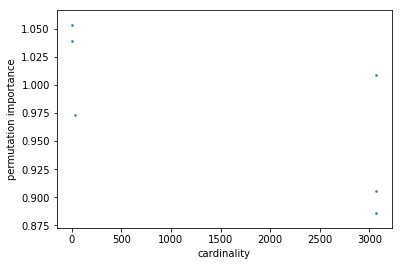

In [36]:
cardinalities = []
for predictor in predictors:
    card_p = len(np.unique(data[predictor]))
    cardinalities.append(card_p)
imp_vals = [perm_imp[i] for i in predictors]
plt.scatter(cardinalities, imp_vals, s=3, alpha=0.8)
plt.ylabel('permutation importance')
plt.xlabel('cardinality')
plt.show()

Another thing we can do is put in a random noise variable (similar to one of our own variables), retrain a model and see how the permutation of this particular variable affects the change in loss. We can try to use the mean of numCon to sample some poisson noise.

In [37]:
numcon_mean = np.mean(data['numCon'])
poisson_noise = np.random.poisson(lam=numcon_mean, size=data.shape[0])

In [38]:
pancrea_trainx_rdm = np.c_[(pancrea_trainx, poisson_noise[0:pancrea_trainx.shape[0]])]
pancrea_testx_rdm = np.c_[(pancrea_testx, poisson_noise[pancrea_trainx.shape[0]:])]
rf_rdm = RandomForestRegressor(n_estimators=500, max_features=int(round(len(predictors)/3)))
rf_rdm.fit(pancrea_trainx_rdm, pancrea_trainy)
predictors_rdm = predictors+['poisson_noise']

In [39]:
sklearn_perm_imp_rdm = permutation_importance(rf_rdm, pancrea_testx_rdm, pancrea_testy, n_repeats = 10, 
                                         scoring = 'neg_mean_squared_error')

feat_imp_perm_rdm_sklearn = dict(zip(predictors_rdm, sklearn_perm_imp_rdm['importances_mean']))
{k: v for k, v in sorted(feat_imp_perm_rdm_sklearn.items(), key=lambda item: item[1])}

{'hole_area_smooth': -262.99897777615195,
 'solidity': -223.8379612344992,
 'period': -59.57917880338173,
 'poisson_noise': -4.100114239318191,
 'eccentricity': 40.03003944322336,
 'numEnds': 60.45956888148021,
 'numCon': 189.32521985891307}

Look at ratios instead of loss differences.

In [40]:
feat_importances_rdm = get_feature_importance(n_shuffles=10, predictor_variables=predictors_rdm, X=pancrea_testx_rdm, 
                                              Y=pancrea_testy, scoring_type='ratio', model=rf_rdm)
feat_importances_rdm

{'hole_area_smooth': 0.9318411046464159,
 'solidity': 0.9497787971789184,
 'period': 0.9882586036946024,
 'poisson_noise': 0.9993947080257108,
 'numEnds': 1.0101262555917199,
 'eccentricity': 1.012920787037459,
 'numCon': 1.0464869257586467}

Check if our random poisson noise is correlated with other features

In [41]:
np.corrcoef(pancrea_trainx_rdm.T)[:, 6]

array([ 4.44629048e-04,  3.30262699e-03, -1.14641559e-02, -1.79739152e-02,
       -1.83193304e-02,  3.03703714e-02,  1.00000000e+00])

In [42]:
np.corrcoef(pancrea_trainx_rdm.T)

array([[ 1.00000000e+00,  5.20708481e-01,  2.15466694e-01,
         2.51226439e-01, -1.82629318e-01, -3.00068380e-02,
         4.44629048e-04],
       [ 5.20708481e-01,  1.00000000e+00,  1.54721456e-01,
         1.39765297e-01, -1.11469858e-01,  1.37734409e-01,
         3.30262699e-03],
       [ 2.15466694e-01,  1.54721456e-01,  1.00000000e+00,
         1.00078895e-01,  4.60787894e-02, -6.18830056e-02,
        -1.14641559e-02],
       [ 2.51226439e-01,  1.39765297e-01,  1.00078895e-01,
         1.00000000e+00, -4.84158388e-02, -4.85780371e-01,
        -1.79739152e-02],
       [-1.82629318e-01, -1.11469858e-01,  4.60787894e-02,
        -4.84158388e-02,  1.00000000e+00, -3.88140819e-01,
        -1.83193304e-02],
       [-3.00068380e-02,  1.37734409e-01, -6.18830056e-02,
        -4.85780371e-01, -3.88140819e-01,  1.00000000e+00,
         3.03703714e-02],
       [ 4.44629048e-04,  3.30262699e-03, -1.14641559e-02,
        -1.79739152e-02, -1.83193304e-02,  3.03703714e-02,
         1.0000000

Since we are a bit concerned about period, we can try dropping it quickly and fit a model and then look at test loss.

In [43]:
rf_no_period = RandomForestRegressor(n_estimators=500, max_features=2)
rf_no_period.fit(pancrea_trainx[:, [i!='period' for i in predictors]], pancrea_trainy)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [44]:
print(squared_loss(rf_sklearn.predict(pancrea_testx), pancrea_testy))
print(squared_loss(rf_no_period.predict(pancrea_testx[:, [i!='period' for i in predictors]]), pancrea_testy))

4505.359148982333
4608.708096585367


(for the cheating split of data we had a lower loss with period than without, but here it's like whatever)

We can also check a binary classifier, since we are also interested in saying whether or not a hole is closing. Let's say that negative dAdt = 1 and positive = 0. 
Since the classes are uneven, we will use the area under the ROC curve (implemented in SKlearn) for evaluating performance on the model on the test set
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score

In [45]:
def binarize_labels(y):
    vector = np.copy(y)
    vector[vector>=0] = 0
    vector[vector<0] = 1
    return(vector)
binarized_train = binarize_labels(pancrea_trainy)
binarized_test = binarize_labels(pancrea_testy)

In [46]:
default_classifier = RandomForestClassifier()
default_classifier.fit(pancrea_trainx, binarized_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [47]:
# quickly check train accuracy
default_classifier.score(pancrea_trainx, binarized_train)

1.0

In [48]:
default_classifier.classes_

array([0., 1.])

Again we try some grid searching, using the same grid as before.

In [49]:
rf_class = RandomForestClassifier()
grid_search_class = GridSearchCV(estimator = rf_class, param_grid = param_grid, 
                          cv = 5, n_jobs = 2, verbose = 1, scoring='roc_auc')

grid_search_class.fit(pancrea_trainx, binarized_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  55 tasks      | elapsed:   24.4s
[Parallel(n_jobs=2)]: Done 205 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 240 out of 240 | elapsed:  1.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [50]:
grid_search_class.best_params_

{'max_depth': None,
 'max_features': 6,
 'min_samples_leaf': 1,
 'n_estimators': 10}

In [51]:
best_classifier = RandomForestClassifier(max_depth = grid_search_class.best_params_['max_depth'], 
                                        max_features = grid_search_class.best_params_['max_features'], 
                                        min_samples_leaf = grid_search_class.best_params_['min_samples_leaf'], 
                                        n_estimators = grid_search_class.best_params_['n_estimators'])
best_classifier.fit(pancrea_trainx, binarized_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [52]:
# quickly evaluate test set performance
print(best_classifier.score(pancrea_testx, binarized_test))
print(roc_auc_score(binarized_test, best_classifier.predict_proba(pancrea_testx)[:, 1]))

0.6048
0.6899058298140867


Let's check what sort of feature importance we get from this model.


In [53]:
# mean decrease impurity
mdi_classifier = dict(zip(predictors, best_classifier.feature_importances_))
{k: v for k, v in sorted(mdi_classifier.items(), key=lambda item: item[1])}

{'numCon': 0.030974166124405,
 'numEnds': 0.05001639472767282,
 'period': 0.061389921607708633,
 'hole_area_smooth': 0.2692747753804728,
 'solidity': 0.2921491984621051,
 'eccentricity': 0.2961955436976357}

In [54]:
# permutation
feat_importances_classifier = get_feature_importance(n_shuffles=10, predictor_variables=predictors, 
                                                     X=pancrea_testx, Y=binarized_test, scoring_type='ratio', 
                                                     model=best_classifier, loss_type='auc')

In [55]:
# permutation sklearn, sanity check but also difference (i.e. (1-auc_perm) - (1-auc_base)) instead of ratio
sklearn_perm_imp_classifier = permutation_importance(best_classifier, pancrea_testx, binarized_test, n_repeats = 10, 
                                         scoring = 'roc_auc')
feat_imp_perm_sklearn_classifier = dict(zip(predictors, sklearn_perm_imp_classifier['importances_mean']))
{k: v for k, v in sorted(feat_imp_perm_sklearn_classifier.items(), key=lambda item: item[1])}

{'numCon': -0.0036648706373477503,
 'numEnds': 0.01657019076743844,
 'period': 0.03384241056259395,
 'solidity': 0.06260193679918444,
 'eccentricity': 0.11376086112324639,
 'hole_area_smooth': 0.1596208921896995}

Compare feature importances for regressor and classifier (permutation)

In [56]:
print("regressor feature importances")
perm_imp

regressor feature importances


{'hole_area_smooth': 0.8856710240086418,
 'solidity': 0.9051913247567412,
 'period': 0.9730425987898644,
 'eccentricity': 1.0084039628834143,
 'numEnds': 1.0392361499426581,
 'numCon': 1.05336328352487}

In [57]:
print('classifier feature importances: ')
feat_importances_classifier

classifier feature importances: 


{'numCon': 0.9910871521934801,
 'numEnds': 1.066645795014284,
 'period': 1.0999745626736583,
 'solidity': 1.2383692717097794,
 'eccentricity': 1.3705533596837942,
 'hole_area_smooth': 1.4503522091339565}

Let's try to see what range the threshold values fall into for each feature. We'll use the classifier. In order to get an idea of how to do this we inspect what's in the tree_ class.

In [58]:
print(dir(best_classifier.estimators_[0].tree_), )

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', 'apply', 'capacity', 'children_left', 'children_right', 'compute_feature_importances', 'compute_partial_dependence', 'decision_path', 'feature', 'impurity', 'max_depth', 'max_n_classes', 'n_classes', 'n_features', 'n_leaves', 'n_node_samples', 'n_outputs', 'node_count', 'predict', 'threshold', 'value', 'weighted_n_node_samples']


In [59]:
best_classifier.estimators_[0].tree_.node_count

311

In [60]:
np.unique(best_classifier.estimators_[0].tree_.feature, return_counts=True)

(array([-2,  0,  1,  2,  3,  4,  5]),
 array([156,   4,   3,  11,  39,  51,  47]))

In [61]:
best_classifier.estimators_[0].tree_.n_leaves

156

If the feature is -2 that means the node is a leaf.

In [62]:
def feature_thresholds(thresholds, features_tree, real_var_names):
    tree_to_real_var = {k: v for k, v in enumerate(real_var_names)}
    thresholds_per_feature = {key: [] for key in real_var_names}
    def append_thresholds(feature_num, threshold):
        if feature_num >-1:
            feature_real = tree_to_real_var[feature_num]
            thresholds_per_feature[feature_real].append(threshold)
        return None
    for i in range(0, thresholds.shape[0]):
        append_thresholds(features_tree[i], thresholds[i])
    return(thresholds_per_feature)

In [63]:
# features encoded as numbers
print(np.unique(best_classifier.estimators_[0].tree_.feature[best_classifier.estimators_[0].tree_.feature>=0]))
print(predictors)

[0 1 2 3 4 5]
['numCon', 'numEnds', 'period', 'hole_area_smooth', 'eccentricity', 'solidity']


In [64]:
thresholds_per_feature_per_tree = []
for estimator in best_classifier.estimators_:
    tree = estimator.tree_
    thresholds_per_feature = feature_thresholds(tree.threshold, tree.feature, predictors)
    thresholds_per_feature_per_tree.append(thresholds_per_feature)
thresholds_concatenated = {key: [] for key in predictors}
for tree_values in thresholds_per_feature_per_tree:
    for pred in predictors:
        thresholds_concatenated[pred] += tree_values[pred]
#[len(thresholds_concatenated[key]) for key in thresholds_concatenated.keys()]

Now that we have the thresholds let's try to plot them along with the distribution of the features.

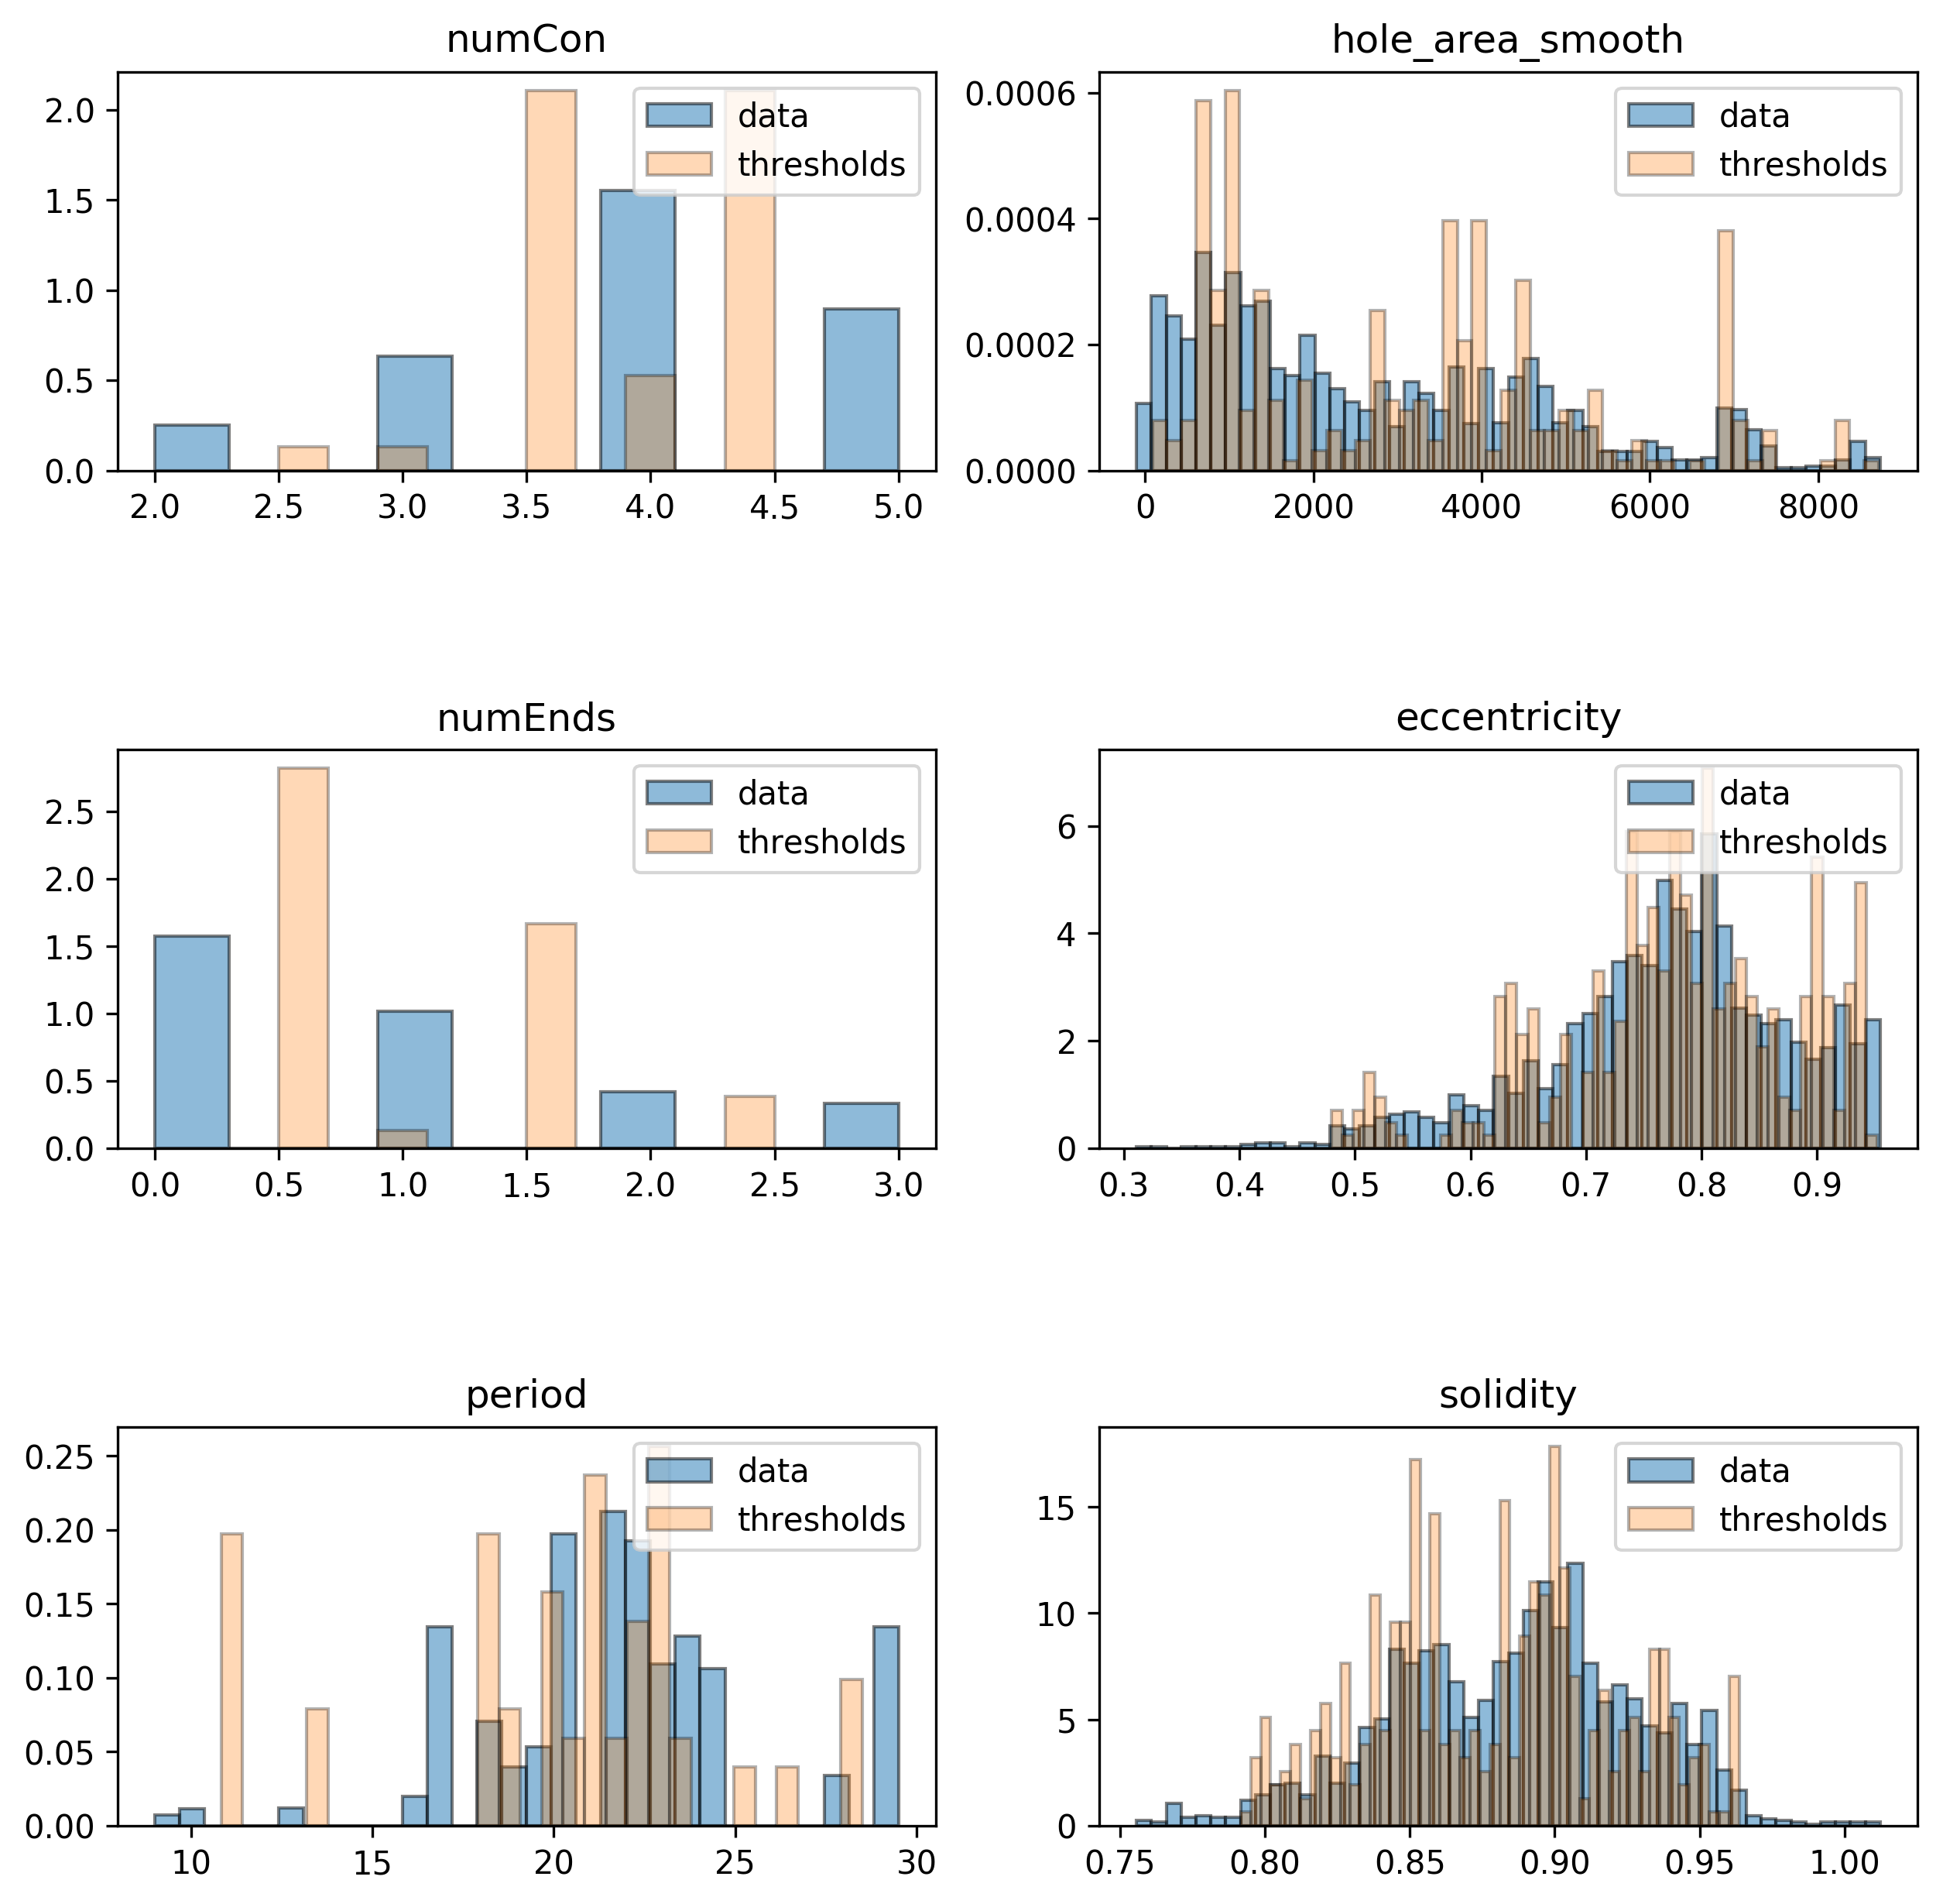

In [65]:
plt_alpha_data = 0.5
plt_alpha_thresh = 0.3
fig, ax = plt.subplots(3, 2, figsize=(10,10), dpi=300)
bins_mid = 30
bins_high = 50
fig.subplots_adjust(hspace=0.7)
ax[0, 0].hist(pancrea_trainx[:, 0], alpha=plt_alpha_data, label='data', density=True, edgecolor='black')
ax[0, 0].hist(thresholds_concatenated['numCon'], alpha=plt_alpha_thresh, label='thresholds', 
              density=True, edgecolor='black')
ax[0, 0].legend(loc='upper right')
ax[0, 0].set_title('numCon')

ax[1, 0].hist(pancrea_trainx[:, 1], alpha=plt_alpha_data, label='data', density=True, edgecolor='black')
ax[1, 0].hist(thresholds_concatenated['numEnds'], alpha=plt_alpha_thresh, label='thresholds', 
              density=True, edgecolor='black')
ax[1, 0].legend(loc='upper right')
ax[1, 0].set_title('numEnds')

ax[2, 0].hist(pancrea_trainx[:, 2], alpha=plt_alpha_data, label='data', density=True, edgecolor='black',
             bins=bins_mid)
ax[2, 0].hist(thresholds_concatenated['period'], alpha=plt_alpha_thresh, label='thresholds', 
              density=True, edgecolor='black', bins=bins_mid)
ax[2, 0].legend(loc='upper right')
ax[2, 0].set_title('period')

ax[0, 1].hist(pancrea_trainx[:, 3], alpha=plt_alpha_data, label='data', density=True, edgecolor='black',
             bins=bins_high)
ax[0, 1].hist(thresholds_concatenated['hole_area_smooth'], alpha=plt_alpha_thresh, label='thresholds', 
              density=True, edgecolor='black', bins=bins_high)
ax[0, 1].legend(loc='upper right')
ax[0, 1].set_title('hole_area_smooth')

ax[1, 1].hist(pancrea_trainx[:, 4], alpha=plt_alpha_data, label='data', density=True, edgecolor='black', 
              bins=bins_high)
ax[1, 1].hist(thresholds_concatenated['eccentricity'], alpha=plt_alpha_thresh, label='thresholds',
              density=True, edgecolor='black', bins=bins_high)
ax[1, 1].legend(loc='upper right')
ax[1, 1].set_title('eccentricity')

ax[2, 1].hist(pancrea_trainx[:, 5], alpha=plt_alpha_data, label='data', density=True, edgecolor='black',
             bins=bins_high)
ax[2, 1].hist(thresholds_concatenated['solidity'], alpha=plt_alpha_thresh, label='thresholds', 
              density=True, edgecolor='black', bins=bins_high)
ax[2, 1].legend(loc='upper right')
ax[2, 1].set_title('solidity')

plt.show()


In [66]:
# as short side note, we can actually also export trees in a graphical form as a pdf (regression trees are huge though)
#import graphviz
#from sklearn.tree import export_graphviz
#dot_data = export_graphviz(rf_sklearn.estimators_[0])
#graph = graphviz.Source(dot_data) 
#graph.render("iris") 

Let's try to see how the decrease in impurity depends on the thresholds.

In [67]:
# let's confirm that the indices of the child nodes and n samples actually give us what we want
best_classifier.estimators_[0].tree_.n_node_samples[0]==best_classifier.estimators_[0].tree_.n_node_samples[best_classifier.estimators_[0].tree_.children_left[0]]+best_classifier.estimators_[0].tree_.n_node_samples[best_classifier.estimators_[0].tree_.children_right[0]]

True

We'll make some functions for this. These functions are not the most efficient and are a bit spaghetti-ish, but they get the job done. Exercise for the reader: remove some unnecessary loops by storing things in arrays instead of dictionaries for every node.

In [68]:
def impurity_decrease(estimator, real_var_names):
    tree = estimator.tree_

    tree_to_real_var = {k: v for k, v in enumerate(real_var_names)}
    indices_nonleaf = np.arange(0, tree.feature.shape[0])[tree.feature > -1]
    N_0 = tree.n_node_samples[0]

    def weighted_impurity_decrease_per_node(node_index):
        N_t = tree.n_node_samples[node_index]
        impurity_t = tree.impurity[node_index]
        left_child = tree.children_left[node_index]
        right_child = tree.children_right[node_index]
        left_impurity = tree.impurity[left_child]
        right_impurity = tree.impurity[right_child]
        N_t_l = tree.n_node_samples[left_child]
        N_t_r = tree.n_node_samples[right_child]

        weighted_impurity_decrease = N_t*impurity_t - N_t_l*left_impurity - N_t_r*right_impurity
        weighted_impurity_decrease = weighted_impurity_decrease/N_0
        return(weighted_impurity_decrease)

    feature_threshold_wimpd = {key: [] for key in real_var_names}
    for i in indices_nonleaf:
        feat_i = tree.feature[i]
        feat_i_real = tree_to_real_var[feat_i]
        threshold = tree.threshold[i]
        wimpd_i = weighted_impurity_decrease_per_node(i)
        dict_i = dict(threshold=threshold, wimpd=wimpd_i)
        #dict_i = dict(threshold=threshold, wimpd=wimpd_i, node_index=i)
        feature_threshold_wimpd[feat_i_real].append(dict_i)
    return(feature_threshold_wimpd)

def concatenate_values_per_estimator(feat_dict):
    feature_keys = feat_dict.keys()
    vals_per_feature = {key: None for key in feature_keys}
    for feature in feature_keys:
        sub_dict_conc = {value_key: [] for value_key in feat_dict[feature][0].keys()}
        for sub_dict in feat_dict[feature]:
            for value_key in sub_dict:
                sub_dict_conc[value_key].append(sub_dict[value_key])
        vals_per_feature[feature] = sub_dict_conc
    return(vals_per_feature)

def concatenate_values_all(list_estimator_dicts):
    features = [key for key in list_estimator_dicts[0].keys()]
    master_dict = {key: None for key in features}
    value_keys = list_estimator_dicts[0][features[0]].keys()
    for key in master_dict.keys():
        master_dict[key]={value_key: [] for value_key in value_keys}
    for feature in features:
        for estimator_dict in list_estimator_dicts:
            for value_key in value_keys:
                master_dict[feature][value_key] += estimator_dict[feature][value_key]
    return(master_dict)

def get_threshold_and_wimpd(estimator_list, variable_names):
    impurity_decreases = [impurity_decrease(estimator, variable_names) for estimator in estimator_list]
    concatenated_values_estimator = [concatenate_values_per_estimator(imp_dec_dict) for imp_dec_dict in
                                     impurity_decreases]
    concatenated_values = concatenate_values_all(concatenated_values_estimator)
    return(concatenated_values)

In [69]:
thresh_wimpds_all = get_threshold_and_wimpd(best_classifier.estimators_, predictors)

We can quickly sanity check that our results are true, since the normalized sums of the wimpds for each feature should be the same as the feature importances calculated with SKLearn's inbuilt method

In [70]:
should_add_to_imp = []
for key in thresh_wimpds_all.keys():
    sum_wimpds = np.sum(thresh_wimpds_all[key]['wimpd'])
    should_add_to_imp.append(sum_wimpds)
should_add_to_imp = [i/sum(should_add_to_imp) for i in should_add_to_imp]
should_add_to_imp

[0.03151477471669621,
 0.05029230690892466,
 0.062255213110334,
 0.2682836617634299,
 0.2943351505189479,
 0.29331889298166725]

In [71]:
best_classifier.feature_importances_

array([0.03097417, 0.05001639, 0.06138992, 0.26927478, 0.29619554,
       0.2921492 ])

Close enough.

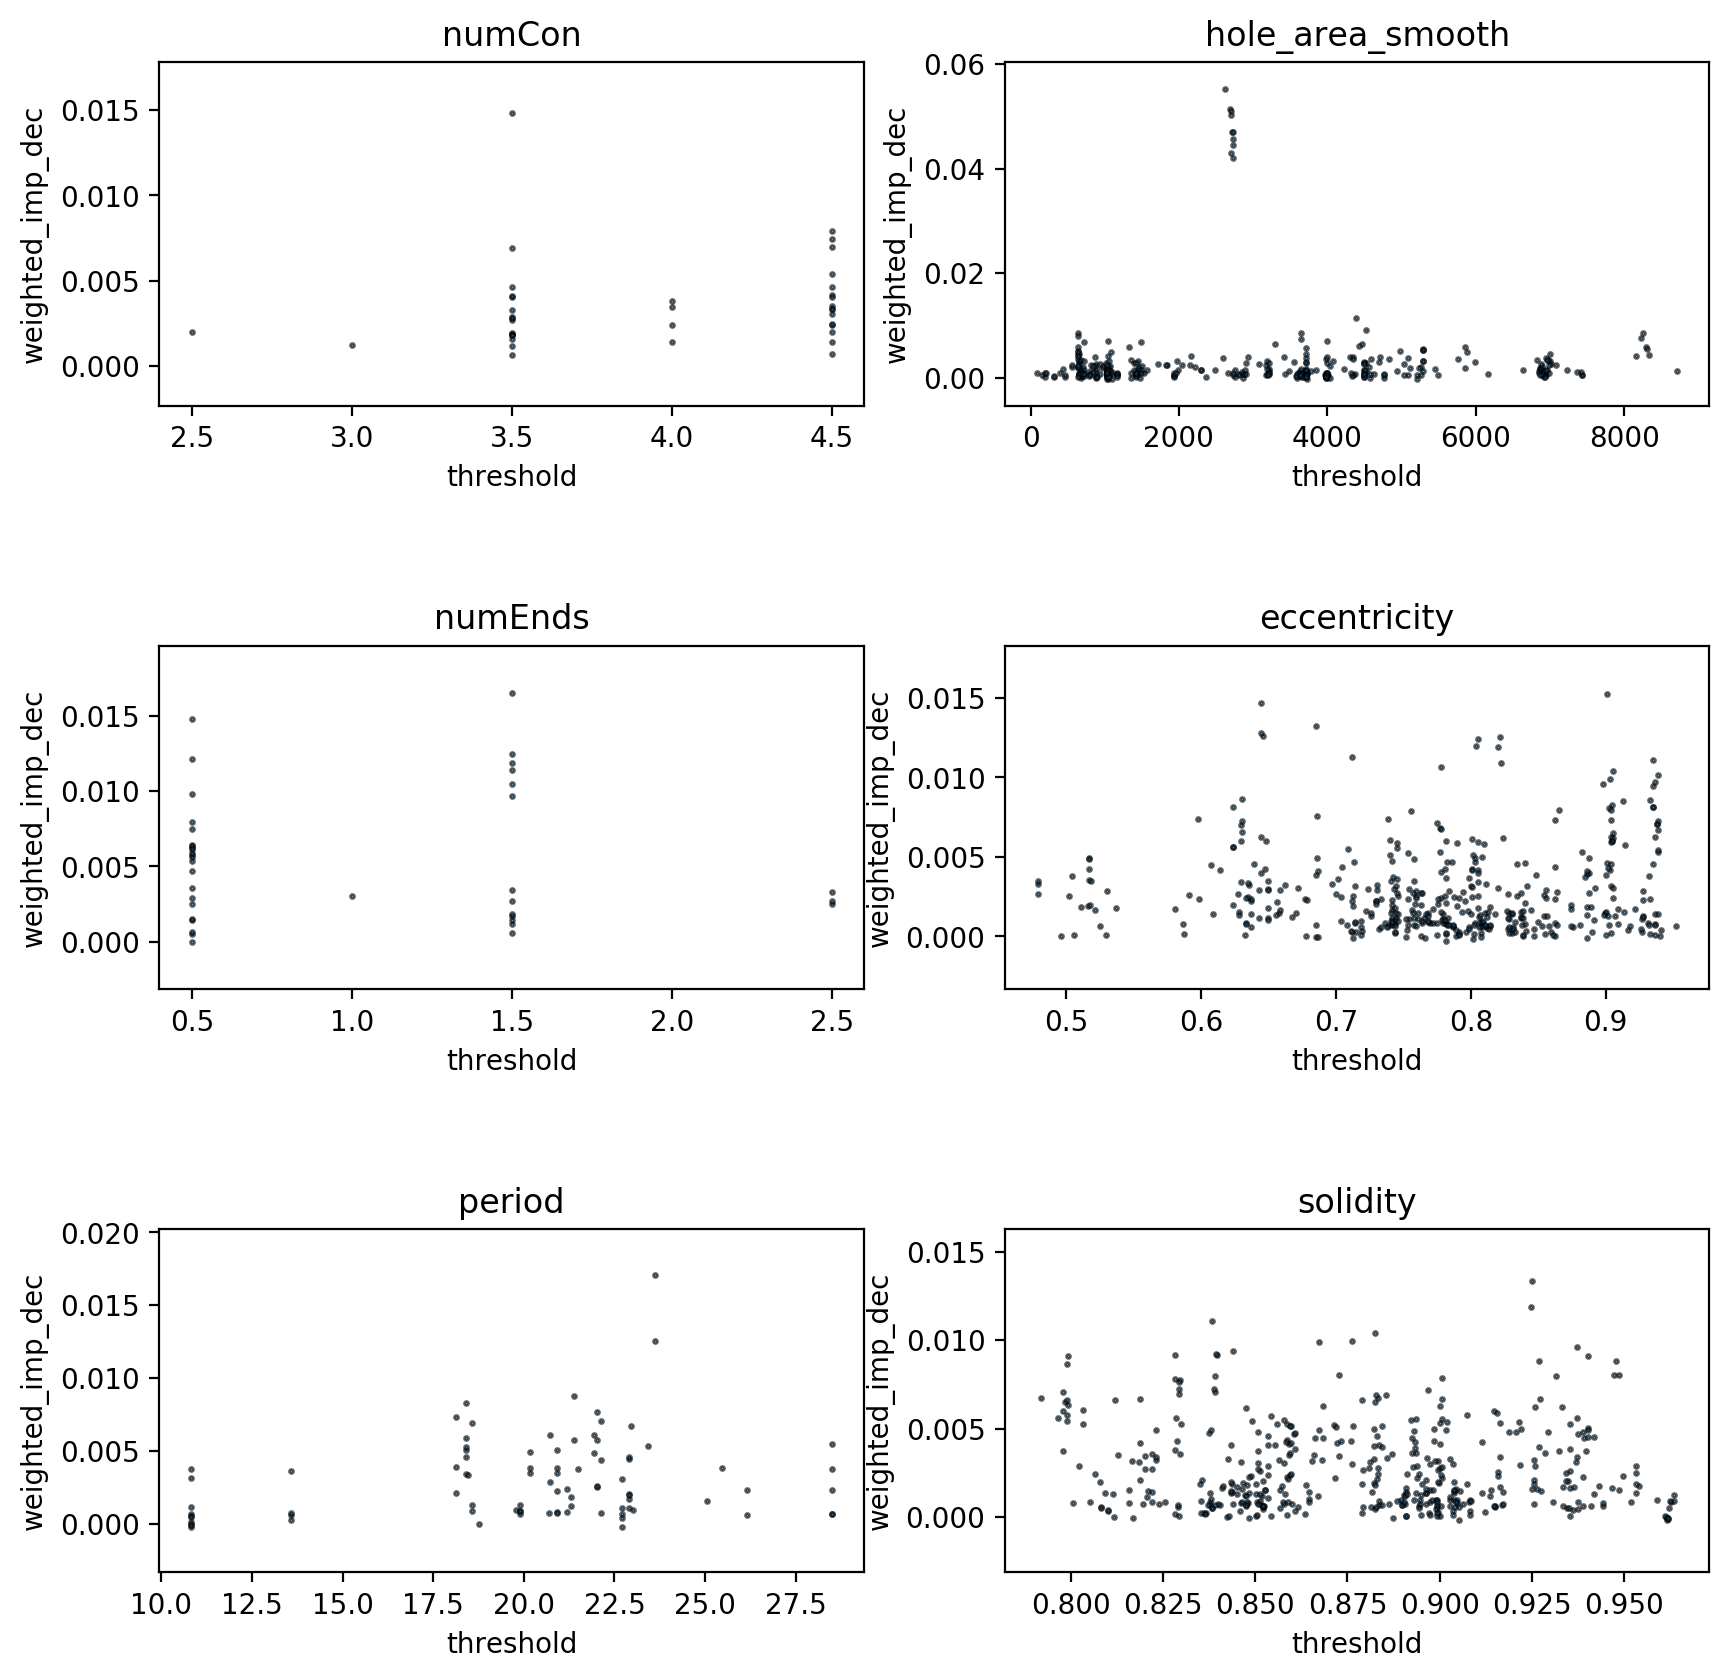

In [72]:
scatter_alpha = 0.6
point_size = 2
plt_alpha_thresh = 0.3
fig, ax = plt.subplots(3, 2, figsize=(10,10), dpi=200)

fig.subplots_adjust(hspace=0.7)
ax[0, 0].scatter(thresh_wimpds_all['numCon']['threshold'], thresh_wimpds_all['numCon']['wimpd'],
                 s=point_size, alpha=scatter_alpha, edgecolor='black')
ax[0, 0].set_title('numCon')
ax[0, 0].set_ylabel('weighted_imp_dec')
ax[0, 0].set_xlabel('threshold')

ax[1, 0].scatter(thresh_wimpds_all['numEnds']['threshold'], thresh_wimpds_all['numEnds']['wimpd'],
                 s=point_size, alpha=scatter_alpha, edgecolor='black')
ax[1, 0].set_title('numEnds')
ax[1, 0].set_ylabel('weighted_imp_dec')
ax[1, 0].set_xlabel('threshold')

ax[2, 0].scatter(thresh_wimpds_all['period']['threshold'], thresh_wimpds_all['period']['wimpd'],
                 s=point_size, alpha=scatter_alpha, edgecolor='black')
ax[2, 0].set_title('period')
ax[2, 0].set_ylabel('weighted_imp_dec')
ax[2, 0].set_xlabel('threshold')

ax[0, 1].scatter(thresh_wimpds_all['hole_area_smooth']['threshold'], thresh_wimpds_all['hole_area_smooth']['wimpd'],
                 s=point_size, alpha=scatter_alpha, edgecolor='black')
ax[0, 1].set_title('hole_area_smooth')
ax[0, 1].set_ylabel('weighted_imp_dec')
ax[0, 1].set_xlabel('threshold')

ax[1, 1].scatter(thresh_wimpds_all['eccentricity']['threshold'], thresh_wimpds_all['eccentricity']['wimpd'],
                 s=point_size, alpha=scatter_alpha, edgecolor='black')
ax[1, 1].set_title('eccentricity')
ax[1, 1].set_ylabel('weighted_imp_dec')
ax[1, 1].set_xlabel('threshold')

ax[2, 1].scatter(thresh_wimpds_all['solidity']['threshold'], thresh_wimpds_all['solidity']['wimpd'],
                 s=point_size, alpha=scatter_alpha, edgecolor='black')
ax[2, 1].set_title('solidity')
ax[2, 1].set_ylabel('weighted_imp_dec')
ax[2, 1].set_xlabel('threshold')

plt.show()

Useful links:
https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/tree/_tree.pyx#1052 <-- contains source code of feature importance

https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/tree/_criterion.pyx#879 <-- contains impurity calculation

https://github.com/scikit-learn/scikit-learn/blob/95d4f0841/sklearn/inspection/_permutation_importance.py#L40 <-- permutation importance calculation

Let's check the performance of a neural network.

In [73]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (50, ), early_stopping=False, solver='adam', n_iter_no_change = 30,
                    learning_rate_init=0.0001, tol=1e-5, max_iter = 500)
clf.fit(pancrea_trainx, binarized_train)
test_probs = clf.predict_proba(pancrea_testx)
test_auc = roc_auc_score(binarized_test, test_probs[:, 1])
print(test_auc)

0.6584995873986699


What about a neural network regressor?

In [74]:
from sklearn.neural_network import MLPRegressor
regrezzor = MLPRegressor(hidden_layer_sizes=(500, 200, ), early_stopping=True)
regrezzor.fit(pancrea_trainx, pancrea_trainy)
test_preds = clf.predict(pancrea_testx)
test_sq_loss = squared_loss(pancrea_testy, test_preds)
print(test_sq_loss)

4201.016889697269


Let's make a grid search with a neural network classifier with 1 layer. Unfortunately it does not seem we can easily change the weight initialization. Note that we should make our own grid search using the metapoints instead of randomly splitting points.

In [75]:
nn_grid = {
    'hidden_layer_sizes': [(50,), (100,), (500,) ],
    'solver': ['sgd', 'adam'],
    'early_stopping': [True, False],
    'learning_rate_init': [1e-3, 1e-4, 1e-5]
}
nn_class = MLPClassifier(max_iter = 500)
grid_search_nn = GridSearchCV(estimator = nn_class, param_grid = nn_grid, 
                          cv = 5, n_jobs = 2, verbose = 1, scoring='roc_auc')

grid_search_nn.fit(pancrea_trainx, binarized_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.2s
[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:  2.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=500, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state...ue,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid={'early_stopping'

In [76]:
grid_search_nn.best_params_

{'early_stopping': False,
 'hidden_layer_sizes': (500,),
 'learning_rate_init': 1e-05,
 'solver': 'adam'}

In [77]:
best_nn = MLPClassifier(early_stopping = grid_search_nn.best_params_['early_stopping'], 
                        hidden_layer_sizes = grid_search_nn.best_params_['hidden_layer_sizes'],
                       learning_rate_init = grid_search_nn.best_params_['learning_rate_init'], 
                       solver = grid_search_nn.best_params_['solver'], 
                       max_iter = 500)
best_nn.fit(pancrea_trainx, binarized_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(500,), learning_rate='constant',
              learning_rate_init=1e-05, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [78]:
best_nn_test_pred = best_nn.predict_proba(pancrea_testx)
roc_auc_score(binarized_test, best_nn_test_pred[:, 1])

0.6211955730304354

Check feature importance of this model.

In [79]:
feat_imp_nn = get_feature_importance(n_shuffles=10, predictor_variables=predictors, X=pancrea_testx, 
                                              Y=binarized_test, scoring_type='ratio', model=best_nn, loss_type='auc')
feat_imp_nn

{'period': 0.9772256927759088,
 'eccentricity': 0.9899439372096747,
 'solidity': 1.0003812269742112,
 'numCon': 1.005247477174435,
 'numEnds': 1.1553195579048534,
 'hole_area_smooth': 1.2838699343264453}

Maybe we can also check the weights of the first layer, weighted by the weights of the second layer.

In [80]:
[i.shape for i in best_nn.coefs_]

[(6, 500), (500, 1)]

In [81]:
weighted_weights = np.multiply(best_nn.coefs_[0], best_nn.coefs_[1].ravel())
weighted_weights = best_nn.coefs_[0]

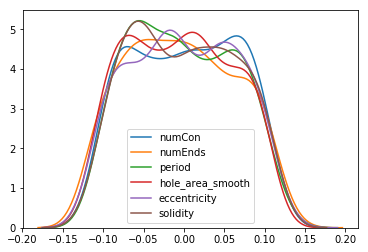

In [82]:
#cmap_hist = plt.cm.rainbow(np.linspace(0, 1, len(predictors)))
import seaborn as sns
#hist_alpha = 0.5
sns.distplot(weighted_weights[0, :], label = predictors[0], hist=False)
sns.distplot(weighted_weights[1, :], label = predictors[1], hist=False)
sns.distplot(weighted_weights[2, :], label = predictors[2], hist=False)
sns.distplot(weighted_weights[3, :], label = predictors[3], hist=False)
sns.distplot(weighted_weights[4, :], label = predictors[4], hist=False)
sns.distplot(weighted_weights[5, :], label = predictors[5], hist=False)
plt.legend()
plt.show()